<a href="https://colab.research.google.com/github/km-0-8/iowa_liqueur/blob/main/liqueur_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 基本情報

[https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/about_data](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/about_data)

| 英語カラム名              | 日本語説明                                      |
|---------------------------|-----------------------------------------------|
| invoice_and_item_number   | 伝票／行番号（Invoice/Item）                    |
| date                      | 注文日（日付）                                 |
| store_number              | 店舗番号                                       |
| store_name                | 店舗名                                         |
| address                   | 住所                                           |
| city                      | 市区町村名                                     |
| zip_code                  | 郵便番号                                       |
| store_location            | 店舗の位置（緯度・経度）                        |
| county_number             | 郡番号（County Number）                        |
| county                    | 郡名                                           |
| category                  | 酒類カテゴリコード                             |
| category_name             | 酒類カテゴリ名                                 |
| vendor_number             | ベンダー番号（Vendor Number）                 |
| vendor_name               | ベンダー名（Vendor）                          |
| item_number               | 商品番号（Item Number）                        |
| item_description          | 商品説明（Item Description）                   |
| pack                      | ケース内のボトル数（Pack）                    |
| bottle_volume_ml         | ボトル容量（ミリリットル）                     |
| state_bottle_cost         | 州が仕入れた価格（State Bottle Cost）         |
| state_bottle_retail       | 州の小売価格（State Bottle Retail）           |
| bottles_sold              | 販売本数（Bottle Quantity）                   |
| sale_dollars              | 売上額（Sale Dollars = ボトル×価格）         |
| volume_sold_liters        | 販売量（リットル）                            |
| volume_sold_gallons       | 販売量（ガロン）                              |

##### ライブラリインポート/アカウント認証


In [1]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!python3 --version
!pip install --no-cache-dir
!pip uninstall -y dask distributed cloudpickle pandas fsspec toolz partd dask-ml
!pip install --no-cache-dir \
  numpy==1.26.4 \
  "dask[complete]==2024.5.0" \
  dask-ml==2023.3.24 \
  cloudpickle==3.0.0 \
  pandas==2.2.2 \
  fsspec==2024.3.1 \
  toolz==0.12.1 \
  google-cloud-bigquery \
  pyarrow \
  gcsfs
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
from google.cloud import bigquery
import dask
import dask.dataframe as dd

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from scipy.stats import skew,pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

##### BigQuery公開データセット（Iowa Liquor Sales）の抽出→Parquet化

In [ ]:
project_id = "nodal-element-464703-v7"
client = bigquery.Client(project=project_id)
query = """
SELECT
*
FROM `bigquery-public-data.iowa_liquor_sales.sales`
"""
query_job = client.query(query)
query_job.result()
destination_table = query_job.destination

destination_uri = "gs://iowa_liquor_sales_ml/stage_data/*.parquet"
extract_job = client.extract_table(
    destination_table,
    destination_uri,
    location="US",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET
    )
)
extract_job.result()

##### データの初期クレンジングと軽量化→Parquet化

In [ ]:
gcs_path = "gs://iowa_liquor_sales_ml/stage_data/*.parquet"
stage_df = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

In [ ]:
stage_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S19297600099,2014-06-02,4969,LAKE LIQUORS WINE AND SPIRITS,910 N 8TH ST W,CLEAR LAKE,50428,b'\x01\x01\x00\x00\x00?;\xe0\xbabYW\xc0\xdb\xd...,17,CERRO GORDO,...,52598,E & J VS,6,1750,11.83,17.75,3,53.25,5.25,1.39
1,S07871900012,2012-09-24,4376,KUM & GO #6 / MASON CITY,1920 S FEDERAL AVE,MASON CITY,50401,"b'\x01\x01\x00\x00\x00\x0b\t\x18]\xdeLW\xc0""\x...",17,CERRO GORDO,...,43334,CAPTAIN MORGAN SPICED RUM,24,375,4.50,6.74,7,47.18,2.62,0.69
2,S27530800017,2015-08-26,4232,"ELLIOTT'S GENERAL STORE,",23828 HWY J18,MORAVIA,52571,b'\x01\x01\x00\x00\x00EF\x07$a5W\xc0}\xb2b\xb8...,4,APPANOOSE,...,33717,PARAMOUNT SLOE GIN,12,1000,5.42,8.13,5,40.65,5.00,1.32
3,INV-58205200024,2023-05-05,5740,NEW STAR / KNOXVILLE,901 WEST PLEASANT ST,KNOXVILLE,50138,b'\x01\x01\x00\x00\x00\x84m\xd2\x07\xe7FW\xc0\...,<NA>,MARION,...,64870,FIREBALL CINNAMON WHISKEY,48,100,1.00,1.50,192,288.00,19.20,5.07
4,INV-00149500106,2016-09-06,2649,HY-VEE #3 / DUBUQUE,400 LOCUST ST,DUBUQUE,52001,b'\x01\x01\x00\x00\x00ux\x08\xe3\xa7\xaaV\xc0\...,31,DUBUQUE,...,37937,SKOL VODKA,12,1000,4.42,6.63,4,26.52,4.00,1.06


⚡point：今後の処理の軽量化のため以下のカラムを排除
- invoice_and_item_number	：ユニークな値のため粒度が高すぎて意味を持たない。
- volume_sold_gallons：他の特徴量から導出される冗長な情報（目的は解釈性の高いモデルの作成であるため）

In [ ]:
df_dropped=stage_df.drop(columns=['invoice_and_item_number','volume_sold_gallons','store_location'])
df_dropped.to_parquet("gs://iowa_liquor_sales_ml/cleaned_data/first_cleaned", write_index=False)

##### 重複確認と欠損値処理→Parquet化

In [ ]:
gcs_path = "gs://iowa_liquor_sales_ml/cleaned_data/first_cleaned/*.parquet"
first_cleaned_df = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

重複行を確認します。（レコード数もついでに確認します。）

In [ ]:
print(f"レコード数（重複削除前）: {first_cleaned_df.shape[0].compute()}")
print(f"レコード数（重複削除後）: {first_cleaned_df.drop_duplicates().shape[0].compute()}")

レコード数（重複削除前）: 31761718


重複行は見つかりませんでした。

全体の欠損数を確認します。

In [ ]:
#first_cleaned_dfの各列の欠損数を確認
first_cleaned_df.isnull().sum().compute()

,0
date,0
store_number,0
store_name,0
address,83896
city,83895
zip_code,83962
county_number,7628875
county,160698
category,16974
category_name,25040


これらの欠損値の処理については情報のまとまりごとに考えます。  
カラムには大きく二つの要素(店舗の位置情報、リキュールの関連情報)に分かれていることが見て取れます。

まず、店舗の位置情報に関する欠損値の処理を考えます。
店舗の位置情報に関するカラムすべてが欠損しているレコードに関しては、相互補完の余地がなく特徴量としての意味を持たないためデータから除外することを考えます。

In [ ]:
#店舗の位置情報に関するカラムを定義
cols = ["address", "city", "zip_code", "county_number", "county"]
null_rows = first_cleaned_df[cols].isnull().all(axis=1)
null_count = first_cleaned_df[null_rows].shape[0].compute()
print(f"店舗の位置情報がすべて null のレコード数: {null_count}")

店舗の位置情報がすべて null のレコード数: 83895


⚡point：8万/3000万レコードと全体の0.3%程度であるためそのまま削除する。

In [ ]:
#店舗の位置情報がすべて null のレコードを削除
df_geo_null_cleaned = first_cleaned_df[~null_rows]
#削除後の欠損数を確認
df_geo_null_cleaned[cols].isnull().sum().compute()

,0
address,1
city,0
zip_code,67
county_number,7544980
county,76803


削除後、county_numberとcountyにまだ欠損値が残っていることがわかります。
このうち、countyはcounty_numberに比べ欠損値が少なく、他の特徴量からの補完による情報精度の低下の影響が少ないと考えられるため、countyを補完することを考えます。

⚡point：addressはほぼ欠損が無く、情報として安定していると考えられるため同一のaddressを持つレコードからcountryを補完します。

In [ ]:
#補完
address_to_county = (
    df_geo_null_cleaned[~df_geo_null_cleaned["county"].isnull()][["address", "county"]]
    .drop_duplicates()
    .compute()
)
address_to_county = address_to_county.dropna()
df_geo_null_cleaned = df_geo_null_cleaned.merge(address_to_county, on="address", how="left", suffixes=("", "_from_address"))
df_geo_null_cleaned["county"] = df_geo_null_cleaned["county"].fillna(df_geo_null_cleaned["county_from_address"])
df_geo_null_cleaned = df_geo_null_cleaned.drop(columns=["county_from_address"])

#補完後の欠損値を確認
df_geo_null_cleaned[cols].isnull().sum().compute()

,0
address,1
city,0
zip_code,67
county_number,7627582
county,5036


⚡point：contryの残りnull数は5千/3000万レコードと全体の0.02%程度であるためそのまま削除する。またaddress, zip_codeについても同様の理由からレコードごと削除します。

In [ ]:
cols = ["address", "zip_code", "county"]
df_geo_null_cleaned = df_geo_null_cleaned[~df_geo_null_cleaned[cols].isnull().any(axis=1)]

In [ ]:
df_null_cleaned =df_geo_null_cleaned

次にリキュールに関する情報の欠損値を確認します。

In [ ]:
df_liq_null_cleaned=df_null_cleaned

In [ ]:
#リキュールに関する情報のカラムを定義
cols = ["category", "category_name", "vendor_number", "vendor_name", "item_number","item_description","pack","bottle_volume_ml","state_bottle_cost","state_bottle_retail","bottles_sold","sale_dollars","volume_sold_liters"]
df_liq_null_cleaned[cols].isnull().sum().compute()

,0
category,17028
category_name,25212
vendor_number,11
vendor_name,9
item_number,0
item_description,0
pack,0
bottle_volume_ml,0
state_bottle_cost,10
state_bottle_retail,10


まず、category と category_nameの欠損値について考えます。
これらが両方とも欠損している場合、相互補完の余地がなくなるためまずは存在するかどうかを確認します。その他の列に関しては欠損レコードが重複していないと仮定しても合計41レコードしかないためそのまま削除します。

In [ ]:
null_count = df_liq_null_cleaned[(df_liq_null_cleaned["category"].isnull()) & (df_liq_null_cleaned["category_name"].isnull())].shape[0].compute()
print(f"category と category_name がともに null のレコード数: {null_count}")

category と category_name がともに null のレコード数: 17028


⚡point：この条件に当てはまるレコード数は1.7万/3000万と全体に対して0.05%程度の数であるため、そのままレコードごと削除します。

In [ ]:
df_liq_null_cleaned = df_liq_null_cleaned[~df_liq_null_cleaned["category"].isnull()]
cols = ["vendor_number", "vendor_name", "state_bottle_cost", "state_bottle_retail","sale_dollars"]
df_liq_null_cleaned = df_liq_null_cleaned[~df_liq_null_cleaned[cols].isnull().any(axis=1)]

全ての欠損値処理が完了した後の欠損数をもう一度確認します。

In [ ]:
df_liq_null_cleaned.isnull().sum().compute()

,0
date,0
store_number,0
store_name,0
address,0
city,0
zip_code,0
county_number,7622524
county,0
category,0
category_name,8176


⚡point：county_numberやcategory_nameはcountyやcategoryが信頼できる情報かどうか判断するため、このまま残します。

In [ ]:
df_null_cleaned =df_liq_null_cleaned

In [ ]:
df_null_cleaned.to_parquet("gs://iowa_liquor_sales_ml/cleaned_data/null_cleaned", write_index=False)

#####  冗長カラムの削除と表記ゆれの整理によるデータクレンジング→Parquet化

In [ ]:
gcs_path = "gs://iowa_liquor_sales_ml/cleaned_data/null_cleaned/*.parquet"
null_cleaned_df = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

類似するカラムの組合せが複数あり、どちらの情報が正しいのか精査する必要があるため調査します。

In [ ]:
def find_conflicts_and_print(df, id_col, name_col):
    conflicts = (
        df.groupby(id_col)[name_col]
        .nunique()
        .reset_index()
        .rename(columns={name_col: f"distinct_{name_col}"})
    )
    conflicts_filtered = conflicts[conflicts[f"distinct_{name_col}"] > 1]
    conflict_ids = conflicts_filtered[id_col].compute()
    conflict_df = df[df[id_col].isin(conflict_ids)][[id_col, name_col]]
    conflict_df = conflict_df.drop_duplicates().compute()
    print(f"\nConflicts for {id_col} vs {name_col}:")
    print(conflict_df.sort_values(id_col))

find_conflicts_and_print(null_cleaned_df, "store_number", "store_name")
find_conflicts_and_print(null_cleaned_df, "county_number", "county")
find_conflicts_and_print(null_cleaned_df, "category", "category_name")
find_conflicts_and_print(null_cleaned_df, "vendor_number", "vendor_name")
find_conflicts_and_print(null_cleaned_df, "item_number", "item_description")


Conflicts for store_number vs store_name:
       store_number                                         store_name
5221          10023  HY-VEE FAST AND FRESH #3 (7592) / WEST DES MOINES
11017         10023         HY-VEE FAST AND FRESH #3 / WEST DES MOINES
129825        10024         HY-VEE FAST AND FRESH #2 / WEST DES MOINES
10705         10024  HY-VEE FAST AND FRESH #2 (7591) / WEST DES MOINES
30551         10025        HY-VEE FAST AND FRESH #4 (7583) / URBANDALE
...             ...                                                ...
76060          9051                      WILDCAT DISTILLING / DUNCOMBE
156832         9052                          173 CRAFT DISTILLERY (ET)
83122          9052                               173 CRAFT DISTILLERY
14319          9911                             NORTH AMERICAN SPIRITS
22199          9911            SOUTHERN GLAZERS WINE & SPIRITS OF IOWA

[804 rows x 2 columns]

Conflicts for county_number vs county:
Empty DataFrame
Columns: [county_number, 

✅insight
- store_number vs store_nam：表記ゆれがある
  - store_numberに対して同一の内容であると目視で判断し、store_numberの情報を信頼。冗長なstore_nameは削除しstore_numberのみ残す
- county_number vs country：1:1の関係。
  - 冗長なcountryは削除しcounty_numberのみ残す

- category vs category_name：表記ゆれがある
  - categoryに対して同一の内容であると考え、categoryの情報を信頼。冗長なcategory_nameは削除しcategoryのみ残す

- vendor_number vs vendor_name：表記ゆれがある
  - vendor_numberに対して同一の内容であると考え、vendor_numberの情報を信頼。冗長なvendor_nameは削除しvendor_numberのみ残す

- item_number vs item_description：表記ゆれがある
  - item_numberに対して同一の内容であると考え、item_numberの情報を信頼。冗長なitem_descriptionは削除しitem_numberのみ残す

In [ ]:
df_redundant_del = null_cleaned_df.drop(columns=['store_name',"address","city","zip_code", 'county_number',"category_name","vendor_name","item_description"])
df_redundant_del.to_parquet("gs://iowa_liquor_sales_ml/cleaned_data/redundant_del", write_index=False)

##### データ型の変換と外れ値除去、特徴量エンジニアリング→Parquet化

In [3]:
gcs_path = "gs://iowa_liquor_sales_ml/cleaned_data/redundant_del/*.parquet"
df_redundant_del = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

In [4]:
df_redundant_del.head()

,date,store_number,county,category,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
0,2014-06-02,4969,CERRO GORDO,1051010.0,205,52598,6,1750,11.83,17.75,3,53.25,5.25
1,2012-09-24,4376,CERRO GORDO,1062310.0,260,43334,24,375,4.50,6.74,7,47.18,2.62
2,2015-08-26,4232,APPANOOSE,1041200.0,434,33717,12,1000,5.42,8.13,5,40.65,5.00
3,2023-05-05,5740,MARION,1081600.0,421,64870,48,100,1.00,1.50,192,288.00,19.20
4,2016-09-06,2649,DUBUQUE,1031100.0,55,37937,12,1000,4.42,6.63,4,26.52,4.00


vendor_numberとcategoryの表示を統一するため一度整数に変換し、再度文字列に戻します。

In [5]:
df_redundant_del["vendor_number"] = df_redundant_del["vendor_number"].map_partitions(
    lambda part: part.astype(float).astype(int).astype(str),
    meta=("vendor_number", str)
)

df_redundant_del["category"] = df_redundant_del["category"].map_partitions(
    lambda part: part.astype(float).astype(int).astype(str),
    meta=("category", str)
)

外れ値の確認をするため、記述統計量を表示します。

In [6]:
numeric_df = df_redundant_del.select_dtypes(include=["number"])
numeric_df.describe().compute().applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
count,"31,986,864.00","31,986,864.00","31,986,864.00","31,986,864.00","31,986,864.00","31,986,864.00","31,986,864.00"
mean,12.08,870.45,10.97,16.47,10.95,147.91,9.15
std,7.81,617.09,13.60,20.39,30.80,520.79,36.47
min,1.00,0.00,0.00,0.00,-768.00,"-9,720.00","-1,344.00"
25%,6.00,750.00,5.78,8.67,3.00,37.14,1.50
50%,12.00,750.00,8.66,13.01,6.00,78.66,4.80
75%,12.00,"1,000.00",13.17,19.82,12.00,153.00,10.50
max,336.00,"378,000.00","24,989.02","37,483.53","15,000.00","279,557.28","15,000.00"


✅insight：以下のカラムにおいて現実的に起こりえない外れ値(異常値とみなす)があることがわかります。
- state_bottle_cost	：0はあり得ないため排除
- bottles_sold：0以下は異常値のため排除
- sale_dollars：0以下は異常値のため排除
- state_bottle_retail：0はあり得ないため排除

外れ値を排除します。

In [7]:
df_redundant_del = df_redundant_del[
    (df_redundant_del["bottle_volume_ml"] > 0) &
    (df_redundant_del["state_bottle_cost"] > 0) &
    (df_redundant_del["bottles_sold"] > 0) &
    (df_redundant_del["state_bottle_retail"] > 0) &
    (df_redundant_del["sale_dollars"] > 0)
]

次に特徴量生成を行います。

今回は時系列予測は行いませんが、時系列データの特徴量として有効なラグ特徴量を生成します。

In [8]:
#ラグ特徴量の生成
lag_cols = ['sale_dollars', 'bottles_sold', 'volume_sold_liters', 'state_bottle_cost', 'state_bottle_retail']
agg_pdf = df_redundant_del.groupby(['store_number', 'date'])[lag_cols].sum().compute().reset_index()

for col in lag_cols:
    for lag in [1, 7, 30]:
        agg_pdf[f'{col}_lag_{lag}'] = (
            agg_pdf.groupby('store_number')[col].shift(lag)
        )

rename_dict = {col: f'date_store_{col}_sum' for col in lag_cols}
agg_pdf = agg_pdf.rename(columns=rename_dict)
agg_ddf_with_lag = dd.from_pandas(agg_pdf, npartitions=df_redundant_del.npartitions)
df_redundant_del = df_redundant_del.merge(agg_ddf_with_lag, on=['store_number', 'date'], how='left')

ラグ特徴量生成時に発生したnanは中央値で補完します。

In [9]:
#発生したnanを中央値で補完
lag_cols=['sale_dollars_lag_1','sale_dollars_lag_7','sale_dollars_lag_30',
          'bottles_sold_lag_1','bottles_sold_lag_7', 'bottles_sold_lag_30',
          'volume_sold_liters_lag_1','volume_sold_liters_lag_7', 'volume_sold_liters_lag_30',
          'state_bottle_cost_lag_1', 'state_bottle_cost_lag_7','state_bottle_cost_lag_30',
          'state_bottle_retail_lag_1','state_bottle_retail_lag_7', 'state_bottle_retail_lag_30']
for col in lag_cols:
  median_value = df_redundant_del[col].compute().median()
  df_redundant_del[col] = df_redundant_del[col].fillna(median_value)

その他、重要だと考えられる特徴量も併せて生成します。

In [10]:
#リットル単価
df_redundant_del["sales_per_L"]=df_redundant_del["sale_dollars"]/df_redundant_del["volume_sold_liters"]
# 日付列をdatetime型に変換
df_redundant_del["date"] = dd.to_datetime(df_redundant_del["date"])

df_redundant_del["year"] = df_redundant_del["date"].dt.year#年
df_redundant_del["month"] = df_redundant_del["date"].dt.month#月
df_redundant_del["day_of_week"] = df_redundant_del["date"].dt.dayofweek#曜日
holidays = calendar.holidays(start="2012-01-01", end="2025-12-31")
df_redundant_del["is_holiday"] = df_redundant_del["date"].isin(holidays)#休日

##### 分布と変数間の関連性の可視化

メモリクラッシュ回避のため、グラフとして描画するデータは全体データの1%とします。

In [11]:
sample_df = df_redundant_del.sample(frac=0.01).compute()

量的変数の分布を確認します。

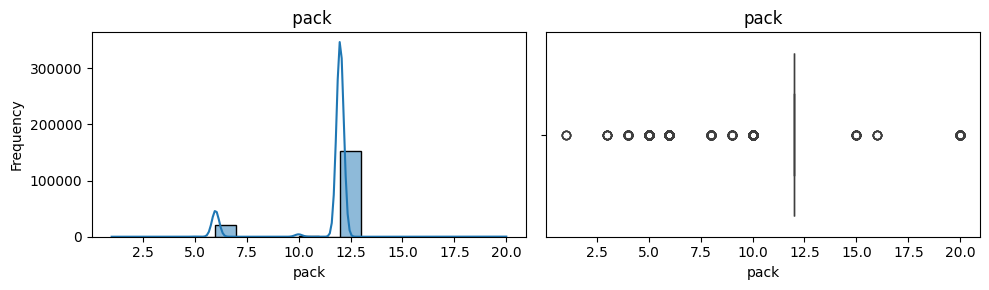

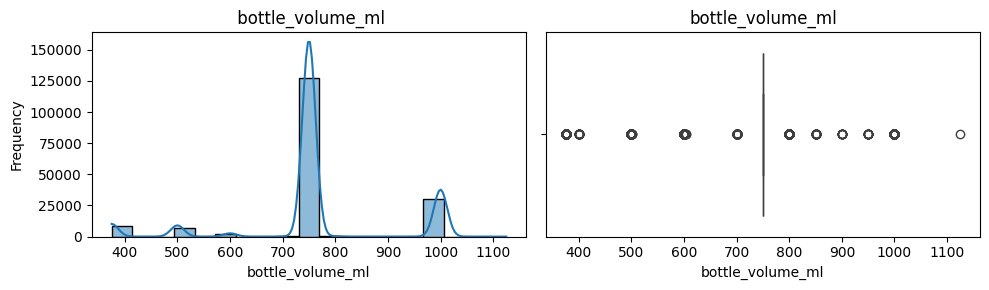

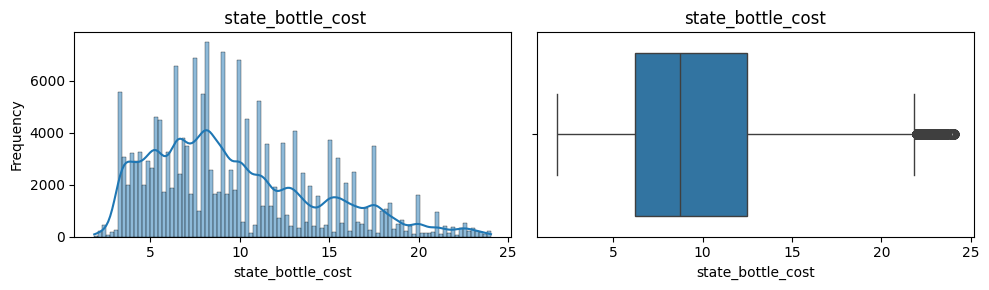

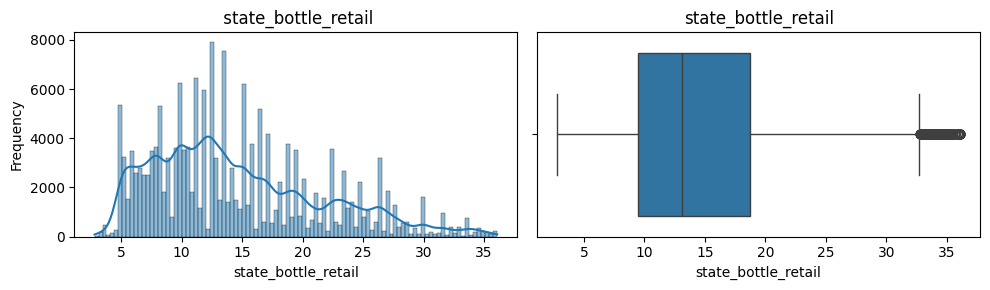

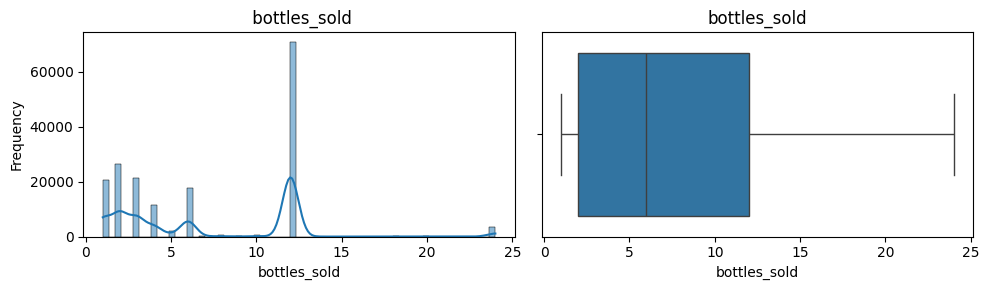

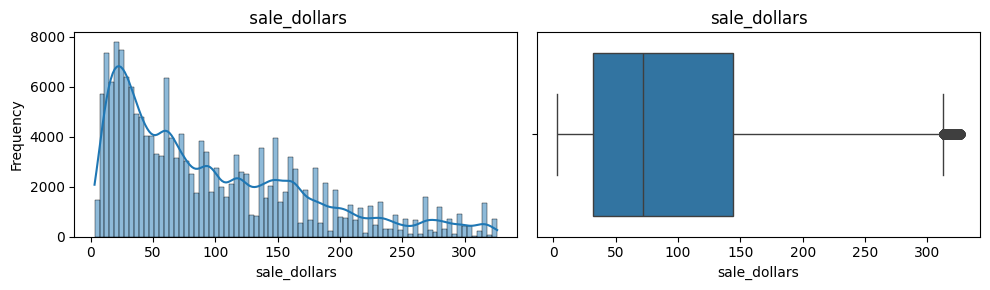

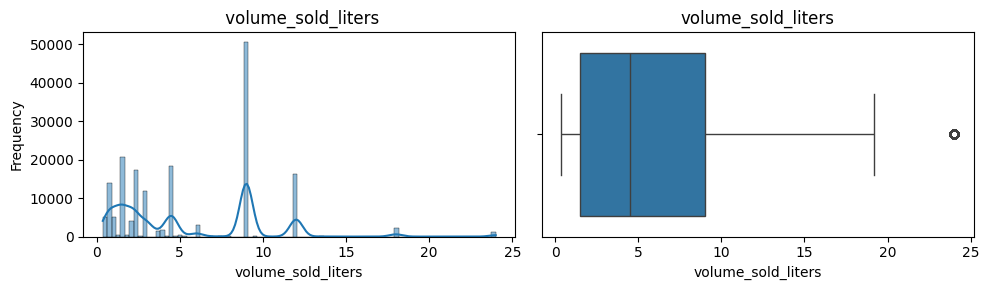

In [12]:
numerical_cols=["pack","bottle_volume_ml","state_bottle_cost","state_bottle_retail","bottles_sold","sale_dollars","volume_sold_liters"]

Q1 = sample_df[numerical_cols].quantile(0.25)
Q3 = sample_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

sample_df_cleaned = sample_df.copy()
for col in numerical_cols:
  sample_df_cleaned = sample_df_cleaned[(sample_df_cleaned[col] >= lower_bound[col]) & (sample_df_cleaned[col] <= upper_bound[col])]

for col in numerical_cols:
  fig, axes = plt.subplots(1, 2, figsize=(10, 3))
  sns.histplot(data=sample_df_cleaned, x=col, ax=axes[0], kde=True)
  axes[0].set_title(f' {col}')
  axes[0].set_xlabel(col)
  axes[0].set_ylabel('Frequency')

  sns.boxplot(data=sample_df_cleaned, x=col, ax=axes[1])
  axes[1].set_title(f'{col}')
  axes[1].set_xlabel(col)
  axes[1].set_ylabel('')

  plt.tight_layout()
  plt.show()

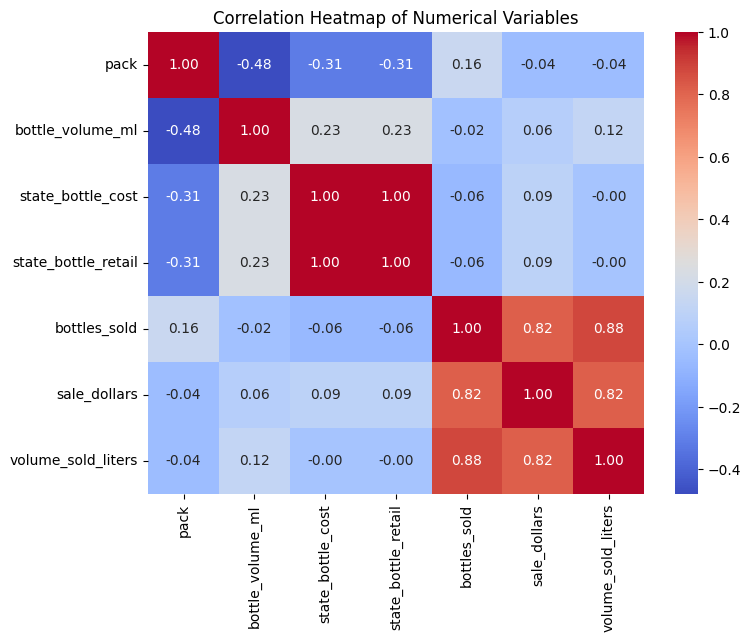

In [21]:
#各変数間の相関
plt.figure(figsize=(8, 6))
sns.heatmap(sample_df[numerical_cols].corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

✅insight：
- volume_sold_littersとbottles_sold高相関な理由：本数が売れるほど、売り上げた総容量も大きくなる
- bottles_sold、volume_sold_littersとsaledollars高相関な理由：総容量が売り上げに貢献している


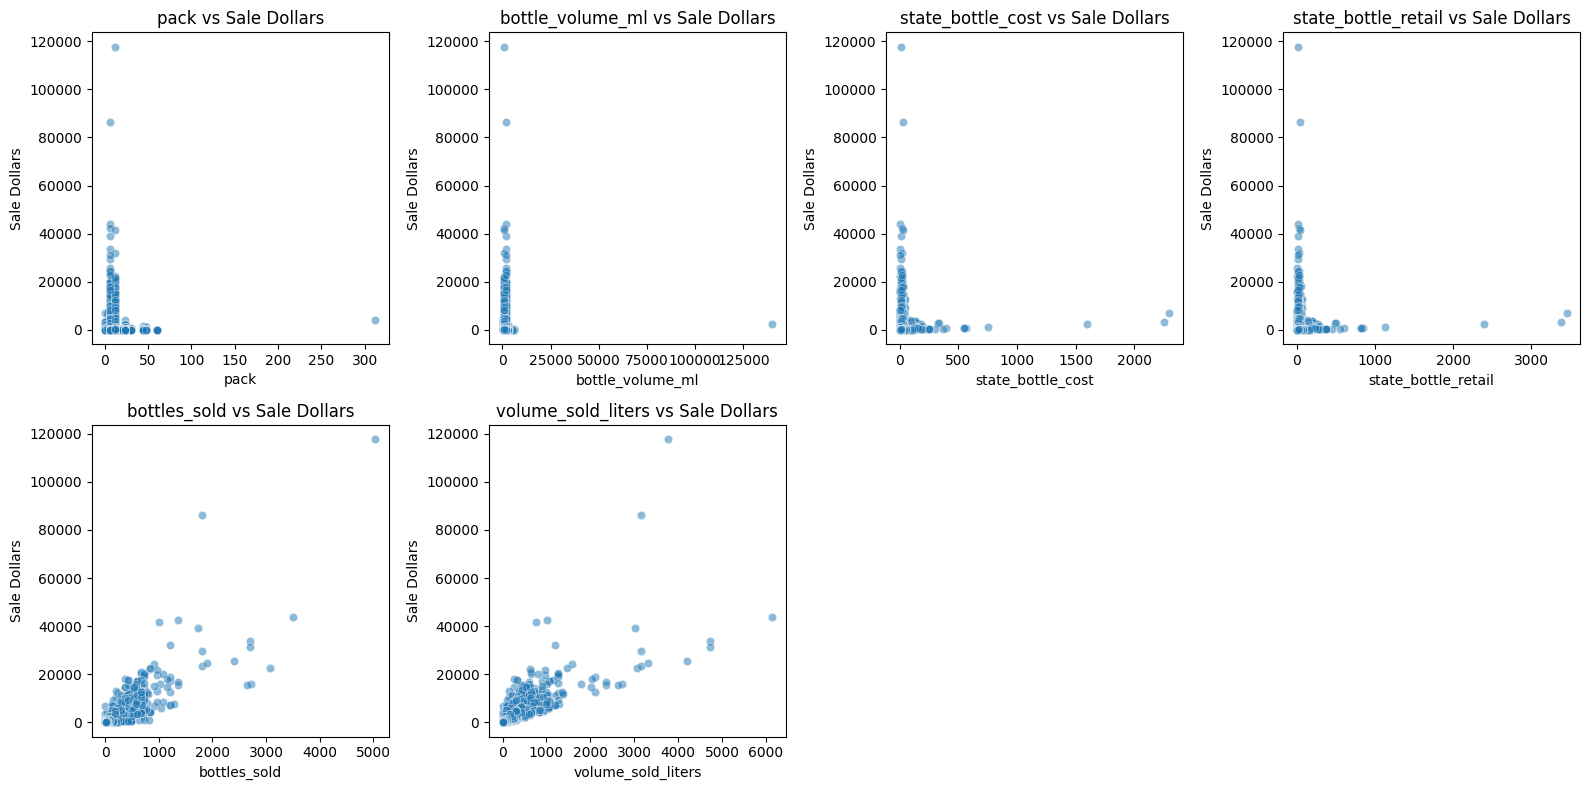

In [23]:
#量的変数と'sale_dollars'の関係性可視化
numeric_cols_excluding_target = numerical_cols
numeric_cols_excluding_target.remove('sale_dollars')

n_cols = 4
n_rows = (len(numeric_cols_excluding_target) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_excluding_target):
    sns.scatterplot(x=col, y='sale_dollars', data=sample_df, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'{col} vs Sale Dollars')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Sale Dollars')

# 残りの空のサブプロットを非表示にする
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
#質的変数の分布
categorical_cols = ['store_number',"county","category","vendor_number",]
value_counts_dict = {}
for col in categorical_cols:
    value_counts_dict[col] = df_redundant_del[col].value_counts().compute().sort_values(ascending=False)
    print(value_counts_dict[col])

store_number
3773     298560
2633     258784
4829     227666
2190     190891
2572     167891
          ...  
9934          2
10572         1
9938          1
9017          1
9937          1
Name: count, Length: 3241, dtype: int64[pyarrow]
county
POLK          5917624
LINN          2795200
SCOTT         1898938
BLACK HAWK    1773782
JOHNSON       1555043
               ...   
WAYNE           25906
DAVIS           21337
RINGGOLD        20710
FREMONT         12611
EL PASO             2
Name: count, Length: 100, dtype: int64[pyarrow]
category
1031100    3420851
1012100    3050255
1011200    2095175
1031200    1566598
1081600    1548157
            ...   
101220           6
1089290          1
1011000          1
1082300          1
1900000          1
Name: count, Length: 114, dtype: int64
vendor_number
260    5192462
421    3178201
65     2864268
434    2653037
370    1839314
        ...   
436          1
853          1
714          1
622          1
855          1
Name: count, Length: 513, dty

✅insight：
- 各カテゴリ変数に偏りがあることがわかります。このままone-Hotエンコーディングを行うのはカラム数が爆発的に増大してしまうため適しません。また、下位〇〇件を"other"とする方法では、個々のカテゴリの意味が失われてしまう可能性があります。よって今回はターゲットエンコーディングを採用します。(中央値で置換)

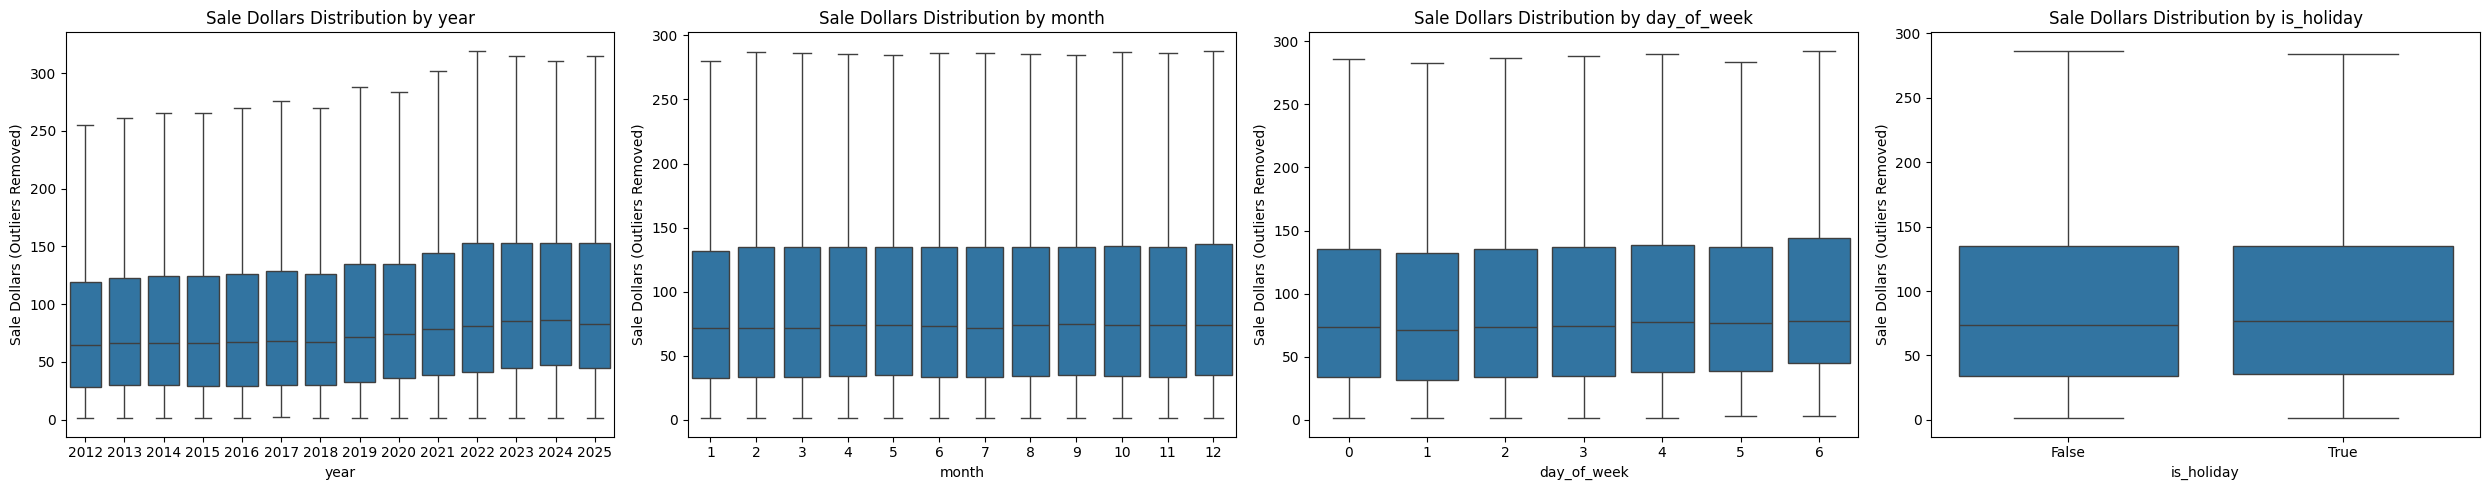

In [20]:
#質的変数(日付関連)と'sale_dollars'の関係性可視化
cols_to_visualize = ['year', 'month', 'day_of_week', 'is_holiday']
fig, axes = plt.subplots(1, len(cols_to_visualize), figsize=(25, 5))

for i, col in enumerate(cols_to_visualize):
    Q1 = sample_df['sale_dollars'].quantile(0.25)
    Q3 = sample_df['sale_dollars'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    trimmed_sale_dollars = sample_df[(sample_df['sale_dollars'] >= lower_bound) & (sample_df['sale_dollars'] <= upper_bound)]
    sns.boxplot(x=col, y='sale_dollars', data=trimmed_sale_dollars, ax=axes[i], showfliers=False)
    axes[i].set_title(f'Sale Dollars Distribution by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Sale Dollars (Outliers Removed)')

plt.tight_layout()
plt.show()

✅insight：
- 2012～2025年にかけて売上のレンジが増大していることがわかります。  
その他比較に関しては、あまり差がないという結果になりました。

In [18]:
df_redundant_del.reset_index(drop=True)[sorted(df_redundant_del.columns)]
df_redundant_del.to_parquet("gs://iowa_liquor_sales_ml/cleaned_data/Feature Eng", write_index=False)

/usr/local/lib/python3.11/dist-packages/dask_expr/_collection.py:301: UserWarning: Dask annotations {'retries': 5} detected. Annotations will be ignored when using query-planning.
  warnings.warn(


##### モデル作成・評価

###### 学習データとテストデータの作成

In [ ]:
gcs_path = "gs://iowa_liquor_sales_ml/cleaned_data/Feature Eng/*.parquet"
all_data = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

In [ ]:
#目的変数の定義
target = "sale_dollars"
#説明変数の定義
quantitative_features = [col for col in all_data.columns if col not in [target, 'date']]

#質的変数の定義
categorical_cols = ['store_number',"county","category","vendor_number","item_number",'year', 'month', 'day_of_week', 'is_holiday']
#量的変数の定義
numeric_cols = [col for col in quantitative_features if col not in categorical_cols]
print("質的変数のカラム名:", categorical_cols)
print("量的変数のカラム名:", numeric_cols)

#重回帰モデル用データをサンプリング
sample_fraction = 0.01
df_sample = all_data.sample(frac=sample_fraction, random_state=42)
df_sample = df_sample.compute()

質的変数のカラム名: ['store_number', 'county', 'category', 'vendor_number', 'item_number', 'year', 'month', 'day_of_week', 'is_holiday']
量的変数のカラム名: ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'volume_sold_liters', 'date_store_sale_dollars_sum', 'date_store_bottles_sold_sum', 'date_store_volume_sold_liters_sum', 'date_store_state_bottle_cost_sum', 'date_store_state_bottle_retail_sum', 'sale_dollars_lag_1', 'sale_dollars_lag_7', 'sale_dollars_lag_30', 'bottles_sold_lag_1', 'bottles_sold_lag_7', 'bottles_sold_lag_30', 'volume_sold_liters_lag_1', 'volume_sold_liters_lag_7', 'volume_sold_liters_lag_30', 'state_bottle_cost_lag_1', 'state_bottle_cost_lag_7', 'state_bottle_cost_lag_30', 'state_bottle_retail_lag_1', 'state_bottle_retail_lag_7', 'state_bottle_retail_lag_30', 'sales_per_L']


⚡point：各カラムについてエンコーディング方法を定義します。
- store_number：ターゲットエンコーディング
- county：ターゲットエンコーディング
- category：ターゲットエンコーディング
- vendor_number：ターゲットエンコーディング
- item_number：ターゲットエンコーディング
- year：そのまま使用
- month： One-Hotエンコーディング
- day_of_week： One-Hotエンコーディング
- is_holiday：そのまま使用

###### エンコーディング

In [ ]:
#ターゲットエンコーディング
target_encoding_cols = ['store_number', 'county', 'category', 'vendor_number',"item_number"]
df_sample_encorded = df_sample.copy()
global_median = df_sample_encorded[target].median()

for col in target_encoding_cols:
    target_median = df_sample_encorded.groupby(col)[target].median()
    df_sample_encorded[col + "_te"] = df_sample_encorded[col].map(target_median)
    df_sample_encorded[col + "_te"] = df_sample_encorded[col].map(target_median).fillna(global_median)
    df_sample_encorded = df_sample_encorded.drop(columns=[col])

quantitative_features_encorded = [col for col in quantitative_features if col not in target_encoding_cols]
quantitative_features_encorded += [col + "_te" for col in target_encoding_cols]

In [ ]:
#one-hotエンコーディング
one_hot_cols = ['month', 'day_of_week']
df_sample_encorded = pd.get_dummies(df_sample_encorded, columns=one_hot_cols, drop_first=False)
#one_hot_colsをdf_sample_encordedから削除
quantitative_features_encorded = [col for col in quantitative_features_encorded if col not in one_hot_cols]
#one_hot_colsをdf_sample_encordedに追加
quantitative_features_encorded += [col for col in df_sample_encorded.columns if col.startswith('month_') or col.startswith('day_of_week_')]

###### 学習用データとテストデータの生成

In [ ]:
# 時系列リークを考慮したスプリット
df_sample = df_sample.sort_values("date")
X = df_sample[quantitative_features]
y = df_sample[target]

n_total = len(df_sample)
n_train = int(n_total * 0.8)
train_idx = list(range(n_train))
test_idx = list(range(n_train, n_total))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

# ターゲットエンコーディング済みも実施
df_sample_encorded = df_sample_encorded.sort_values("date")
X = df_sample_encorded[quantitative_features_encorded]
y = df_sample_encorded[target]

n_total = len(df_sample_encorded)
n_train = int(n_total * 0.8)
train_idx_encorded = list(range(n_train))
test_idx_encorded = list(range(n_train, n_total))

X_train_encorded = X.iloc[train_idx_encorded]
X_test_encorded = X.iloc[test_idx_encorded]
y_train_encorded = y.iloc[train_idx_encorded]
y_test_encorded = y.iloc[test_idx_encorded]

In [ ]:
#加工用のx_trainとx_testを用意
X_train_log_scaled = X_train.copy()
X_test_log_scaled = X_test.copy()
y_train_log_scaled = y_train.copy()
#ターゲットエンコーディング済みも実施
X_train_encorded_log_scaled = X_train_encorded.copy()
X_test_encorded_log_scaled = X_test_encorded.copy()
y_train_encorded_log_scaled = y_train_encorded.copy()

###### 対数変換とスケーリング

In [ ]:
#対数変換（ターゲットエンコーディング済み）
log_scaled_cols= ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'volume_sold_liters','sales_per_L']
skewed_te = X_train_encorded[log_scaled_cols].apply(lambda x: skew(x.dropna()))
skewed_feats_te = skewed_te[skewed_te > 0.75].index
X_train_encorded_log_scaled[skewed_feats_te] = np.log1p(X_train_encorded_log_scaled[skewed_feats_te])
X_test_encorded_log_scaled[skewed_feats_te] = np.log1p(X_test_encorded_log_scaled[skewed_feats_te])
y_train_encorded_log_scaled = np.log1p(y_train_encorded_log_scaled)

#スケーリング
scaler = StandardScaler()
X_train_encorded_log_scaled = scaler.fit_transform(X_train_encorded_log_scaled[quantitative_features_encorded])
X_test_encorded_log_scaled = scaler.transform(X_test_encorded_log_scaled[quantitative_features_encorded])

In [ ]:
# 線形回帰モデルの学習
model = LinearRegression()
model.fit(X_train_encorded_log_scaled, y_train_encorded_log_scaled)

LinearRegression()

In [ ]:
#モデル評価
y_pred = model.predict(X_test_encorded_log_scaled)
y_pred_original = np.expm1(y_pred)

mae = mean_absolute_error(y_test_encorded, y_pred_original)
mse = mean_squared_error(y_test_encorded, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_encorded, y_pred_original)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

MAE: 25.61
MSE: 87522.23
RMSE: 295.84
R-squared: 0.6913


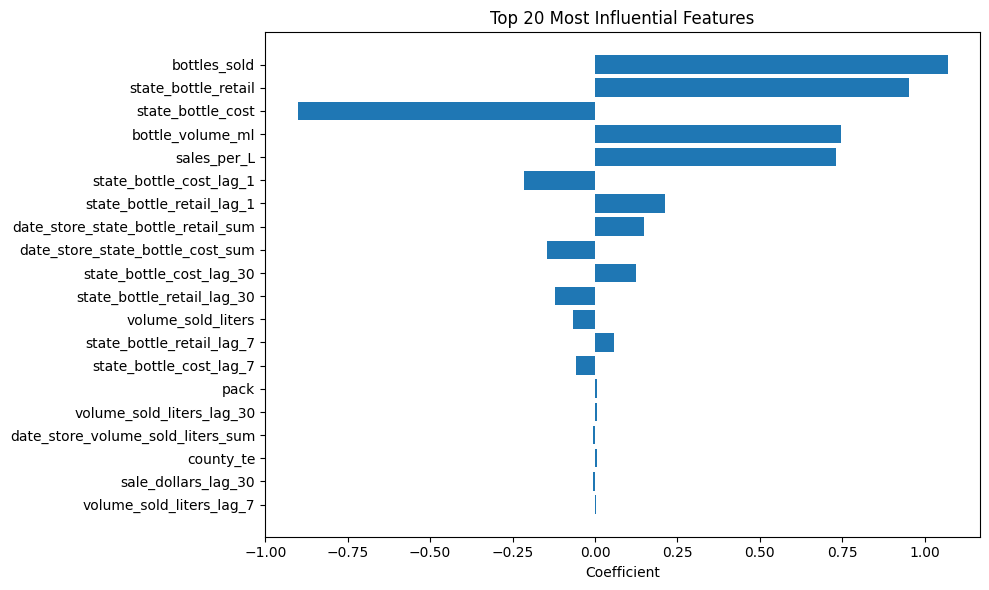

In [ ]:
#特徴量の影響度評価
coef_df = pd.DataFrame({
    "Feature": X_train_encorded.columns,
    "Coefficient": model.coef_
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"].head(20), coef_df["Coefficient"].head(20))
plt.xlabel("Coefficient")
plt.title("Top 20 Most Influential Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()